<b> Word Similarity </b> <br>
Your next step is to evaluate the three kinds of embeddings in the word similarity
task. The goal of this task is to compute similarity of two words and
evaluate the model-produced similarity against human judgements. Download
two commonly-used word similarity datasets:<br>
• SimLex: https://www.cl.cam.ac.uk/˜fh295/simlex.html<br>
• MEN: https://staff.fnwi.uva.nl/e.bruni/MEN<br>
Compute cosine similarity between the words using the three models. Evaluate
the model-produced similarities against human judgements in terms of
Pearson and Spearman correlation coefficients. <br>
Compare the performance of
the three models on this task. <br>
Analyze the data qualitatively and report what
are the differences in the kind of similarity captured by the three models.<br> We
are interested to see both quantitative results and qualitative analysis in your
report.

In [41]:
def read_in_SimLex():
    # Read in the SimLex dataset
    SimLex_file = open('SimLex-999/SimLex-999.txt','r')
    SimLex_set = {}
    next(SimLex_file)
    for line in SimLex_file:
        pair_data = [x.strip() for x in line.split('\t')]
        word1 = pair_data[0]
        word2 = pair_data[1]
        similarity_score = pair_data[4]
        SimLex_set[(word1, word2)] = {'human':similarity_score}
    return SimLex_set


In [42]:
# Read in the MEN dataset
def read_in_MENS():
    MEN_file = open('MEN/MEN_dataset_natural_form_full','r')
    MEN_set = {}
    for line in MEN_file:
        pair_data = [x.strip() for x in line.split(' ')]
        word1 = pair_data[0]
        word2 = pair_data[1]
        similarity_score = pair_data[2]
        MEN_set[(word1, word2)] = {'human':similarity_score}
    return MEN_set

In [43]:
# In order to reduce the size of the word embedding files,
#  I will delete all non-occuring words from the relevant model and
# store the word embeddings in a defaultdict for quick access.
def get_occuring_words(MEN_set, SimLex_set):
    occuring_words = []
    for pair in list(MEN_set.keys())+list(SimLex_set.keys()):
        word1 = pair[0]
        word2 = pair[1]
        if word1 not in occuring_words:
            occuring_words.append(word1)
        if word2 not in occuring_words:
            occuring_words.append(word2)
    return occuring_words

In [44]:
# Read in the word vectors for a given word model
import os
import time
from collections import defaultdict

# switch between 'bow5.words', 'bow2.words' and 'deps.words'
def get_embeddings_specific(filename, occuring_words,name):
    # Returns a dictionary containing words as keys and word vectors
    #  as values
    if filename+'_'+name in os.listdir():
        f = open(filename+'_'+name)
        using_small = True
    else:
        f = open(filename,'r')
        d = open(filename+'_'+name,'w')
        using_small = False
    word_embeddings = defaultdict(list)
    i =0
    s = time.time()
    for line in f:
        entry = [x.strip() for x in line.split(' ')]
        word = entry[0]
        vector = entry[1:]
        if word in occuring_words:
            word_embeddings[word] = [np.float(x) for x in vector]
            if not using_small:
                d.write(line)
    if not using_small:
        d.close()
    f.close()
    e = time.time()
    print('It took {} seconds to read in dataset {}'.format(e-s,filename))
    return word_embeddings



In [45]:
import numpy as np
import math
def cosine_similarity(v1, v2,n1, n2):
    # Returns a value between -1 and 1, 1 meaning exactly same
    #  and -1 meaning exactly opposite.
    assert len(v1) == len(v2)
    numerator = sum([v1[i]*v2[i] for i in range(len(v1))])
    denominator = np.sqrt(sum([x**2 for x in v1])) \
                * np.sqrt(sum([x**2 for x in v2]))
    if denominator == 0:
        print('division by zero with words:')
        print(n1)
        print(n2)
    return (numerator/denominator)

In [46]:

def add_cosine_similarity(dataset, word_embeddings):
    # Computes the cosine similarity per word pair and adds
    #  it to the pair dictionary entry.
    for pair in list(dataset.keys()):
        v1, v2 = word_embeddings[pair[0]], word_embeddings[pair[1]]
        if len(v1) != len(v2):
            if len(v1) == 0 or len(v2) == 0:
                print('Removing {} and {} from dataset'.format(pair[0],pair[1]))
                print('No word embedding found for one of them')
                del dataset[pair]
            else:
                print("Something weird happened with:")
                print(pair[0], pair[1])
        else:
            cos_sim = cosine_similarity(v1,v2,pair[0],pair[1])
            dataset[pair]['cos_sim'] = cos_sim
    return dataset

def get_just_data(dataset):
    # Returns the human judgements and cosine similarities 
    # as a nx2 numpy array for easy data anaylsis
    n = len(dataset)
    result = np.zeros((2,n))
    for i,pair in enumerate(list(dataset.keys())):
        result[0,i] = dataset[pair]['human']
        result[1,i] = dataset[pair]['cos_sim']
        
    return result



In [47]:
# Getting similariy measures for all pairs
def get_similarity_measures(filename):
    s = time.time()
    MEN_set = read_in_MENS()
    SimLex_set = read_in_SimLex()
    occuring_words = get_occuring_words(MEN_set, SimLex_set)
    word_embeddings = get_embeddings_specific(filename,occuring_words,'similarity')
    MEN_set = add_cosine_similarity(MEN_set, word_embeddings)
    SimLex_set = add_cosine_similarity(SimLex_set, word_embeddings)
    MEN_data = get_just_data(MEN_set)
    SimLex_data = get_just_data(SimLex_set)
    e = time.time()
    print('Getting similarity measures on {} took {} seconds'.format(filename,(e-s)))
    return MEN_data, SimLex_data

In [113]:
# Getting most similar pairs
def get_most_similar(dataset):
    cos_sims = []
    pairs = []
    judges= []
    
    for i,pair in enumerate(list(dataset.keys())):
        cos_sims.append(dataset[pair]['cos_sim'])
        pairs.append(pair)
        human_judgement = dataset[pair]['human']
        judges.append(human_judgement)
    cos_sims = np.array([float(x) for x in cos_sims])
    judges = np.array([float(x) for x in judges])
    
    print(len(judges))
    print(max(judges))
    most_cos = [pairs[i] for i in cos_sims.argsort()][-5:]
    most_hum = [pairs[i] for i in judges.argsort()][-5:]
    print("MAX hum{} MAX cos{}".format(max(judges),max(cos_sims)))
    for pair in most_cos:
        print(dataset[pair]['cos_sim'],pair)
    #for pair in most_hum:
        #print(dataset[pair]['human'],pair)
    return most_cos,most_hum

def get_most_similar_pair(filename):
    s = time.time()
    MEN_set = read_in_MENS()
    SimLex_set = read_in_SimLex()
    occuring_words = get_occuring_words(MEN_set, SimLex_set)
    word_embeddings = get_embeddings_specific(filename,occuring_words,'similarity')
    MEN_set = add_cosine_similarity(MEN_set, word_embeddings)
    SimLex_set = add_cosine_similarity(SimLex_set, word_embeddings)
    print("___________________________")
    print("Most similar in MEN set:")
    most_cos_MEN,most_hum_MEN = get_most_similar(MEN_set)
    print("___________________________")
    print("Most similar in SimLex set:")
    most_cos_SimLex, most_hum_SimLex = get_most_similar(SimLex_set)
    e = time.time()
    print('Getting most similar pairs on {} took {} seconds'.format(filename,(e-s)))
    return most_cos_MEN, most_hum_MEN,most_cos_SimLex,most_hum_SimLex

In [115]:
# Get the most similar pairs

#MEN_k2_cospair, MEN_k2_humpair, Sim_k2_cospair,Sim_k2_humpair = get_most_similar_pair('bow2.words')
#MEN_k5_cospair, MEN_k5_humpair, Sim_k5_cospair,Sim_k5_humpair = get_most_similar_pair('bow5.words')
#MEN_deps_cospair, MEN_deps_humpair, Sim_deps_cospair,Sim_deps_humpair = get_most_similar_pair('deps.words')

It took 0.19668245315551758 seconds to read in dataset deps.words
Removing disorganize and organize from dataset
No word embedding found for one of them
___________________________
Most similar in MEN set:
3000
50.0
MAX hum50.0 MAX cos0.8969464911294208
0.8412549781040025 ('carrots', 'potatoes')
0.8684099823248921 ('amphibians', 'mammals')
0.8711636083188342 ('boys', 'girls')
0.8894046932903054 ('mammals', 'reptiles')
0.8969464911294208 ('amphibians', 'reptiles')
___________________________
Most similar in SimLex set:
998
5.0
MAX hum5.0 MAX cos0.9105533563026641
0.8522853260898785 ('movie', 'film')
0.8533453972377322 ('delightful', 'cheerful')
0.871847695465352 ('archbishop', 'bishop')
0.9020725236287033 ('south', 'north')
0.9105533563026641 ('actress', 'actor')
Getting most similar pairs on deps.words took 0.6708941459655762 seconds


In [ ]:
# Read in the three datasets
MEN_k2, Sim_k2 = get_similarity_measures('bow2.words')
MEN_k5, Sim_k5 = get_similarity_measures('bow5.words')
MEN_deps, Sim_deps = get_similarity_measures('deps.words')


In [8]:
# Calculate pearson and spearman correlations
import matplotlib.pyplot as plt
import scipy.stats as ss

def calc_Pearson_correlation(data):
    # data[0,:] are the human observations
    # data[1,:] are the computed cosine similarities
    assert data.shape[0] == 2, 'Data must have two measures per variable.'
    cov_matrix = np.cov(data)
    assert cov_matrix[1,0] == cov_matrix[0,1],'These should be same...'
    cov_hum_cos = cov_matrix[1,0]
    std_hum = np.std(data[0,:])
    std_cos = np.std(data[1,:])
    rho = cov_hum_cos/(std_hum*std_cos)
    return rho

def calc_Spearman_correlation(data):
    # Source https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient
    n = len(data[0,:])
    x = data[0,:]
    y = data[1,:]
    rg_x = ss.rankdata(x)
    rg_y = ss.rankdata(y)
    rg_data = np.array([rg_x,rg_y])
    cov_matrix = np.cov(rg_data)
    assert cov_matrix[1,0] == cov_matrix[0,1],'These should be same...'
    cov_rg_xy = cov_matrix[1,0]
    std_rg_x = np.std(rg_x)
    std_rg_y = np.std(rg_y)
    rho_rg = cov_rg_xy/(std_rg_x*std_rg_y)
    return rho_rg

def pearson_bootstrap_test(data, dataset_name, model_name):
    n = len(data[0,:])
    no_samples = 10000
    sample_size = int(np.floor(n/20))
    rho_full = calc_Pearson_correlation(data)
    rho_samples = []
    for i in range(no_samples):
        rand_idx = np.random.choice(range(n),n,replace=True,)
        sample_data = data[:,rand_idx]
        rho_sample = calc_Pearson_correlation(sample_data)
        rho_samples.append(rho_sample)
    rho_samples.sort()
    rho_lower = rho_samples[int(no_samples*.025)]
    rho_upper = rho_samples[int(no_samples*.975)]
    plt.title('Pearson Correlation Coefficient Boostrap test \n Dataset: {} \n Model: {}'.format(dataset_name, model_name))
    counts,b,p = plt.hist(rho_samples,bins=100)
    label_height = max(counts)
    plt.xlabel(r'$\rho$')
    plt.ylabel('Count')
    plt.axvline(x=rho_full,c='red')
    plt.text(rho_full,label_height,r'$\rho_{pop}$'+": {0:.{1}f}".format(rho_full,3))
    plt.axvline(x=rho_lower,c='red')
    plt.text(rho_lower,label_height,r'$\rho_{lo}$'+": {0:.{1}f}".format(rho_lower,3))
    plt.axvline(x=rho_upper,c='red')
    plt.text(rho_upper,label_height,r'$\rho_{up}$'+": {0:.{1}f}".format(rho_upper,3))
    plt.show()
    return rho_samples


#plt.scatter(Sim_k5[1,:],Sim_k5[0,:])


In [ ]:
# Pearson correlation bootstrap tests

#pearson_bootstrap_test(MEN_k2,'MEN','BOW with k=2')
#pearson_bootstrap_test(MEN_k5,'MEN','BOW with k=5')
#pearson_bootstrap_test(MEN_deps,'MEN','Dependency based')
#pearson_bootstrap_test(Sim_k2,'SimLex','BOW with k=2')
#pearson_bootstrap_test(Sim_k5,'SimLex','BOW with k=5')
#pearson_bootstrap_test(Sim_deps,'SimLex','Dependency based')




In [ ]:
#print(calc_Spearman_correlation(MEN_k2))
#print(calc_Spearman_correlation(MEN_k5))
#print(calc_Spearman_correlation(MEN_deps))
#print(calc_Spearman_correlation(Sim_k2))
#print(calc_Spearman_correlation(Sim_k5))
#print(calc_Spearman_correlation(Sim_deps))

In [9]:
# Get full embeddings of all words
# switch between 'bow5.words', 'bow2.words' and 'deps.words'

def get_embeddings(filename):
    # Returns a dictionary containing words as keys and word vectors
    #  as values
    
    f = open(filename,'r')
    word_embeddings = defaultdict(list)
    s = time.time()
    for line in f:
        entry = [x.strip() for x in line.split(' ')]
        word = entry[0]
        vector = entry[1:]
        word_embeddings[word] = [np.float(x) for x in vector]
    f.close()
    e = time.time()
    print('It took {} seconds to read in dataset {}'.format(e-s,filename))
    return word_embeddings



It took 22.524554014205933 seconds to read in dataset bow5.words


In [10]:
# Read in frequent nouns

f = open('2000_nouns_sorted.txt','r')

freq_nouns = [line.strip() for line in f]
f.close()
noun_embeddings =  get_embeddings_specific('bow5.words',freq_nouns,'freq')



It took 0.26813721656799316 seconds to read in dataset bow5.words


In [11]:
# Cluster and plot frequent nouns with PCA + TSNE

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import pandas as pd 
from ggplot import *
import warnings
warnings.filterwarnings('ignore')


def cluster_plot(nouns, model_name, n_clusters, n_pca):
    noun_embeddings = get_embeddings_specific(model_name,freq_nouns,'freq')
    n = len(list(noun_embeddings.keys()))
    X = np.zeros((n,len(noun_embeddings[list(noun_embeddings.keys())[0]])))
    y = []
    nouns = []
    for i,word in enumerate(list(noun_embeddings.keys())):
        X[i,:] = noun_embeddings[word]
        nouns.append(word)
    # Cluster nouns
    kmeans_model = KMeans(n_clusters=n_clusters,random_state=0).fit(X)
    
    other_labels = None
    
    # If we want to add other words other than the clustered nouns
    # all_embeddings = get_embeddings(model_name)
    # all_keys = list(all_embeddings.keys())
    # rndperm = np.random.permutation(len(all_keys))
    # n_keys = 10000
    # rand_keys = [all_keys[x] for x in rndperm[:n_keys]]
    # for i in range(n_keys):
        # X = np.vstack([X,all_embeddings[rand_keys[i]]])
    # print('Total number of samples: {}'.format(len(X[:,0])))
    # other_labels = [int(x) for x in 10*np.ones(n_keys)] # Labels for non-clustered words
    print(len(noun_embeddings[list(noun_embeddings.keys())[0]]))
    print(len(nouns))
    print(X.shape)
    print(len(kmeans_model.labels_))
    
    # Setup dataframe
    feat_cols = ['dim'+str(i) for i in range(X.shape[1])]
    df = pd.DataFrame(X, columns=feat_cols)
    
    # Get labels
    if other_labels:
        labels = list(kmeans_model.labels_) + other_labels
    else:
        labels = list(kmeans_model.labels_)
    print("Total number of points: {}".format(len(labels)))
    df['label'] = [str(x) for x in labels]
    df['words'] = [str(x) for x in nouns]
    # Reduce dimensionality with PCA
    n_pca_components = n_pca
    pca = PCA(n_components=n_pca_components,random_state=0)
    pca_result = pca.fit_transform(df[feat_cols].values)
    pca_cols = ['pca-'+str(i) for i in range(n_pca_components)]
    for i in range(n_pca_components):
        df['pca-'+str(i)] = pca_result[:,i]
    print('Total explained by the {} components: {}'.format(n_pca_components,sum(pca.explained_variance_ratio_)))
    
    # Visualize data in 2 dimensions with tSNE
    s = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=100,n_iter=2000,random_state=0)
    tsne_results = tsne.fit_transform(df[pca_cols].values)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-s))
    df_tsne = df.loc[:,:].copy()
    
    return df_tsne, tsne_results,kmeans_model
    
    
    
#kmeans_fit =kmeans_model.fit()

/usr/local/lib/python3.5/dist-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/usr/local/lib/python3.5/dist-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


It took 0.27678346633911133 seconds to read in dataset bow2.words
300
1995
(1995, 300)
1995
Total number of points: 1995
Total explained by the 50 components: 0.44664102903971886
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1995 samples in 0.004s...
[t-SNE] Computed neighbors for 1995 samples in 0.486s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1995
[t-SNE] Computed conditional probabilities for sample 1995 / 1995
[t-SNE] Mean sigma: 0.251293
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.769249
[t-SNE] Error after 2000 iterations: 1.625179
t-SNE done! Time elapsed: 132.23790454864502 seconds


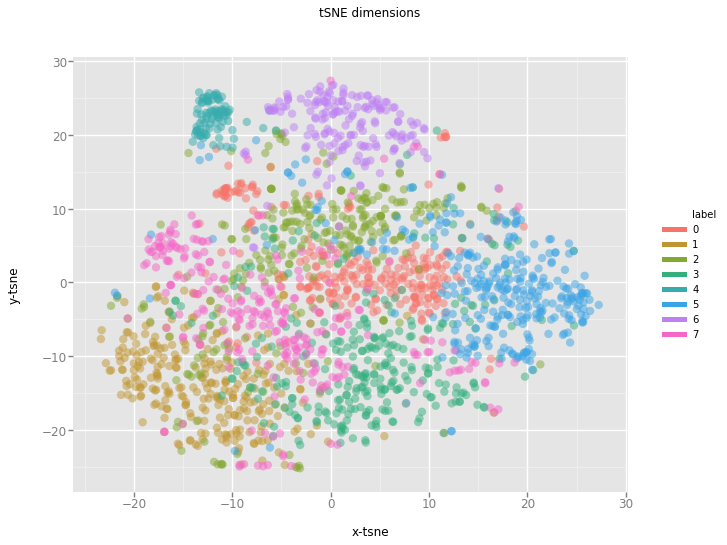

<ggplot: (8748685908849)>

In [12]:
# Actually plot the clusters

df_tsne,tsne_results,model = cluster_plot(freq_nouns,'bow2.words',8,50)
def plot_tsne(df_tsne, tsne_results):
    df_tsne['x-tsne'] = tsne_results[:,0]
    df_tsne['y-tsne'] = tsne_results[:,1]

    chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne',color='label') ) \
            + geom_point(size=70,alpha=0.5) \
            + ggtitle("tSNE dimensions") 

    return chart



chart = plot_tsne(df_tsne, tsne_results)
chart

In [13]:
# Code for getting pairs closest to cluster centers

def euclid_dist(v1, v2):
    assert len(v1) == len(v2), 'Vectors must have equal dimensionality'
    sum_ = sum([((v1[i]-v2[i])**2) for i in range(len(v1))])
    return np.sqrt(sum_)
def get_cluster_distances(model, df):
    # df: pandas dataframe
    centers = model.cluster_centers_
    labels = model.labels_
    feat_cols = ['dim'+str(i) for i in range(300)]
    full_vecs = df[feat_cols].values
    dist_cl = []
    n = len(labels)
    for i in range(n):
        cl_no = labels[i]
        cl_cntr = centers[cl_no]
        vec = full_vecs[i]
        dist_from_cent = euclid_dist(vec,cl_cntr)
        dist_cl.append(dist_from_cent)
    df['distance_center'] = dist_cl
    return df

def get_extremes(df,k,cl_no):
    n = df.shape[0]
    closest = df.loc[df['label']==str(cl_no)].sort_values('distance_center')[:k]
    farthest = df.loc[df['label']==str(cl_no)].sort_values('distance_center')[-k:]
    return closest, farthest

def plot_tsne2(df_tsne,tsne_results,model):
    # This actually gives the closest/ most central words per cluster
    df_tsne['x-tsne'] = x = tsne_results[:,0]
    df_tsne['y-tsne'] = y = tsne_results[:,1]
    print(plt.rcParams['lines.markersize'])
    df_tsne = get_cluster_distances(model,df_tsne)
    plt.figure(figsize=(10,10))
    plt.scatter(x,y,c=df_tsne['label'].values,s=15,alpha=0.5,cmap='gist_rainbow')

    for i in range(8):
        closest,farthest = get_extremes(df_tsne,5,i)
        print('Cluster {} words closest:'.format(i))
        print(closest['words'])
        cl_x = closest['x-tsne']
        cl_y = closest['y-tsne']
        fa_x = farthest['x-tsne']
        fa_y = farthest['y-tsne']
        plt.scatter(cl_x,cl_y,c='g',s=40)
        plt.scatter(cl_x,cl_y,c='w',s=15)
        plt.scatter(fa_x,fa_y,c='r',s=40)
        plt.scatter(fa_x,fa_y,c='w',s=15)
    plt.show()

6.0
Cluster 0 words closest:
1928       town
1985       city
301      church
1421    village
1794    station
Name: words, dtype: object
Cluster 1 words closest:
29        implication
470     contradiction
17         perception
1802        necessity
661       frustration
Name: words, dtype: object
Cluster 2 words closest:
1290    announcement
1462    presentation
1635           story
985            reply
1728            week
Name: words, dtype: object
Cluster 3 words closest:
1643      component
1271    measurement
447     calculation
1266      parameter
1002         method
Name: words, dtype: object
Cluster 4 words closest:
1733     emily
1401     helen
389      susan
532       lucy
93      maggie
Name: words, dtype: object
Cluster 5 words closest:
1888       towel
1083    cupboard
143         tray
1477    forehead
328        thigh
Name: words, dtype: object
Cluster 6 words closest:
924         lawyer
476     journalist
1387     solicitor
1299    researcher
338     accountant
Name: wor

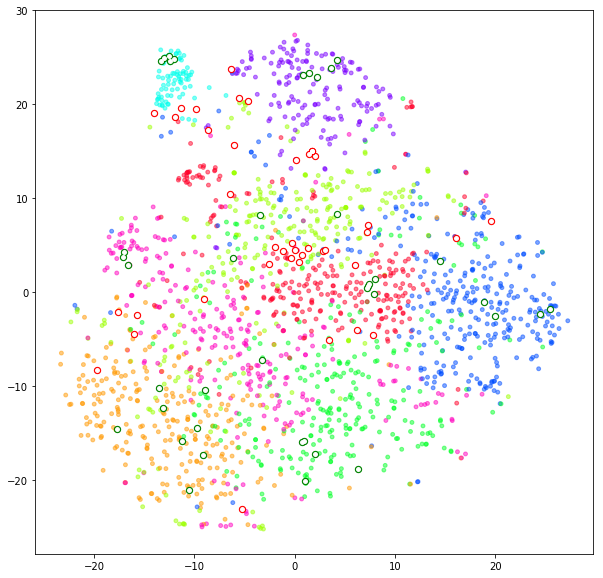

In [14]:

#df = get_cluster_distances(model, df_tsne)
plot_tsne2(df_tsne,tsne_results,model)
 